In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.pipeline import Pipeline


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D


import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import os
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Contest/Titanic_data/train.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [5]:
df.nunique()

,0
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,88
SibSp,7
Parch,7
Ticket,681
Fare,248


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


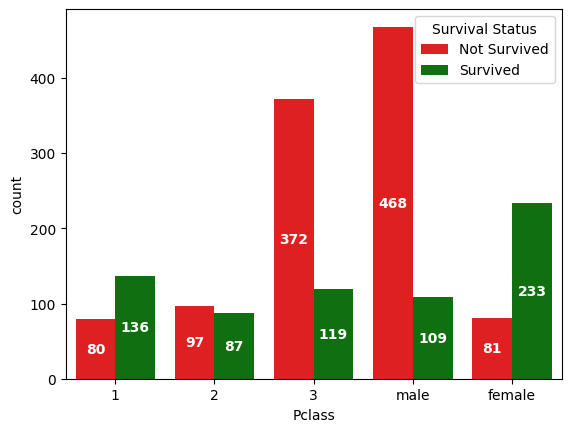

In [7]:
ax=sns.countplot(x='Pclass',data=df,hue='Survived',palette={0: 'red',1:'green'})
ax = sns.countplot(x='Sex', data=df, hue='Survived', palette={0: 'red', 1: 'green'})
ax.legend(title='Survival Status', labels=['Not Survived', 'Survived'])
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=10, fontweight='bold')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [43]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Title
        X['Title'] = X['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
        common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
        X['Title'] = X['Title'].apply(lambda t: t if t in common_titles else 'Rare')
        # FamilySize & IsAlone
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        # Deck
        X['Deck'] = X['Cabin'].fillna('Unknown').str[0]
        # TicketPrefix
        def extract_prefix(ticket):
            ticket = ticket.replace('.', '').replace('/', '')
            parts = ticket.split()
            if len(parts) > 1 and not parts[-1].isdigit():
                return parts[0]
            else:
                return 'None'
        X['TicketPrefix'] = X['Ticket'].apply(extract_prefix)
        # Age imputation by Title group
        age_medians = X.groupby('Title')['Age'].transform('median')
        X['Age'] = X['Age'].fillna(age_medians).fillna(X['Age'].median())
        # Embarked fill
        X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
        return X[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'Deck', 'TicketPrefix']]

In [33]:
X = df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])
y=df['Survived']

In [34]:
numeric_features = ['Age', 'Fare', 'FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # Choose scaler or transformer in grid
    ('scaler', StandardScaler())
])

In [36]:
categorical_features = ['Sex', 'Embarked', 'Title', 'Deck', 'TicketPrefix', 'IsAlone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [37]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [38]:
pipe = Pipeline(steps=[
    ('features', FeatureExtractor()),
    ('preproc', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

In [44]:
param_grid = {
    'preproc__num__scaler': [StandardScaler(), RobustScaler(), QuantileTransformer(output_distribution='normal')],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3,4,5,6,7,10],
    'clf__learning_rate': [0.01,0.05, 0.1, 0.2],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(df, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('features', FeatureExtractor()),
                                       ('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='Mi...
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'clf__max_depth': [3, 4, 5, 6, 7, 10],
                         'clf__n_estimators': [50, 100, 200],
                         'preproc__num__scaler': [StandardScaler(),
                                                  RobustScaler(),
                                                  QuantileTransformer(output_distribution='normal')]},
             scoring='accuracy')

In [41]:
grid.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__n_estimators': 100,
 'preproc__num__scaler': StandardScaler()}

In [45]:
fit_params={
    'preproc__num__scaler':StandardScaler(),
    'clf__n_estimators':100,
    'clf__max_depth':4,
    'clf__learning_rate':0.1
}
pipe.set_params(**fit_params)
pipe.fit(df, y)
pipe.score(df, y)

0.8911335578002245

In [29]:
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Contest/Titanic_data/test.csv')

In [30]:
ypred=pipe.predict(df_test)

In [31]:
output=pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':ypred})
output.to_csv('submission.csv',index=False)